In [1]:
from collections import Counter
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi

# Preprocessing and Model Selection
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve

from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

from catboost import CatBoostClassifier

In [2]:
preprocessed_path = "../data/preprocessed/"

train_df = pd.read_csv(preprocessed_path + "train.csv")
test_df = pd.read_csv(preprocessed_path + "test.csv")
val_df = pd.read_csv(preprocessed_path + "validate.csv")


target = ["TX_FRAUD"]

y_train = train_df[target].values
y_val = val_df[target].values
y_test = test_df[target].values

X_train = train_df.drop(target, axis=1)
X_val = val_df.drop(target, axis=1)
X_test = test_df.drop(target, axis=1)

In [3]:
import optuna
from sklearn.metrics import recall_score, f1_score

# Define the pipeline components
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=1)


def objective(trial):
    # Define the hyperparameters to be tuned
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),
        "random_seed": 123,
        "verbose": False,
    }

    # Create the CatBoost classifier with the suggested hyperparameters
    model = CatBoostClassifier(**params)

    # Create the pipeline
    pipeline = imbpipeline(
        [
            ("preprocessor", scaler),
            ("oversampling", over),
            ("undersampling", under),
            ("classifier", model),
        ]
    )

    # Fit the model on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the validation data
    y_pred = pipeline.predict(X_val)

    # Calculate the recall score
    recall = recall_score(y_val, y_pred)

    return recall


# Create an Optuna study
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///db.sqlite3",
    study_name="quadratic-simple",
    load_if_exists=True,
)

# Optimize the objective function
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Get the best parameters and best recall score
best_params = study.best_params
best_recall = study.best_value

print("Best Parameters:", best_params)
print("Best Recall:", best_recall)

[I 2023-12-19 19:23:26,104] Using an existing study with name 'quadratic-simple' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:23:29,102] Trial 501 finished with value: 0.7064935064935065 and parameters: {'iterations': 350, 'learning_rate': 0.0003696164235801669, 'depth': 6, 'l2_leaf_reg': 2.5705233946877417}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:23:31,800] Trial 502 finished with value: 0.6883116883116883 and parameters: {'iterations': 351, 'learning_rate': 0.000441273124397568, 'depth': 6, 'l2_leaf_reg': 0.3008867341771429}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:23:34,736] Trial 503 finished with value: 0.6961038961038961 and parameters: {'iterations': 374, 'learning_rate': 0.0003917707092533631, 'depth': 6, 'l2_leaf_reg': 3.69293922145137}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:23:37,768] Trial 504 finished with value: 0.6909090909090909 and parameters: {'iterations': 353, 'learning_rate': 0.00035607100636174047, 'depth': 6, 'l2_leaf_reg': 3.3256012495292957}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:23:40,547] Trial 505 finished with value: 0.6909090909090909 and parameters: {'iterations': 334, 'learning_rate': 0.0002452113189981259, 'depth': 6, 'l2_leaf_reg': 1.6154821350613284}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:23:43,832] Trial 506 finished with value: 0.7012987012987013 and parameters: {'iterations': 337, 'learning_rate': 0.0004997703518219676, 'depth': 6, 'l2_leaf_reg': 2.0226167868687517}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:23:47,482] Trial 507 finished with value: 0.7012987012987013 and parameters: {'iterations': 360, 'learning_rate': 0.0006150865648627568, 'depth': 6, 'l2_leaf_reg': 0.5633359713440363}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:23:52,041] Trial 508 finished with value: 0.6519480519480519 and parameters: {'iterations': 521, 'learning_rate': 0.00928854533706062, 'depth': 5, 'l2_leaf_reg': 4.063674553143377}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:23:56,028] Trial 509 finished with value: 0.6883116883116883 and parameters: {'iterations': 366, 'learning_rate': 0.0003737370714781161, 'depth': 6, 'l2_leaf_reg': 0.757680697241178}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:00,039] Trial 510 finished with value: 0.6909090909090909 and parameters: {'iterations': 382, 'learning_rate': 0.00034660545400108466, 'depth': 6, 'l2_leaf_reg': 2.49265152624035}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:09,287] Trial 511 finished with value: 0.6805194805194805 and parameters: {'iterations': 960, 'learning_rate': 0.000315353370709036, 'depth': 6, 'l2_leaf_reg': 0.9351242333624911}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:12,833] Trial 512 finished with value: 0.6935064935064935 and parameters: {'iterations': 341, 'learning_rate': 0.0006615249093426627, 'depth': 6, 'l2_leaf_reg': 0.4809440798369244}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:16,775] Trial 513 finished with value: 0.6909090909090909 and parameters: {'iterations': 396, 'learning_rate': 0.00011194833020268101, 'depth': 6, 'l2_leaf_reg': 1.0921822868842228}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:19,977] Trial 514 finished with value: 0.6857142857142857 and parameters: {'iterations': 310, 'learning_rate': 0.0007755601832554244, 'depth': 6, 'l2_leaf_reg': 0.710430810424972}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:23,273] Trial 515 finished with value: 0.7064935064935065 and parameters: {'iterations': 325, 'learning_rate': 0.0005818913246356643, 'depth': 6, 'l2_leaf_reg': 0.13217243250764157}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:26,459] Trial 516 finished with value: 0.6831168831168831 and parameters: {'iterations': 286, 'learning_rate': 0.0005680691000742008, 'depth': 6, 'l2_leaf_reg': 0.16608197562221458}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:29,622] Trial 517 finished with value: 0.6883116883116883 and parameters: {'iterations': 303, 'learning_rate': 0.000440471466578607, 'depth': 6, 'l2_leaf_reg': 1.1690815483640926}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:32,957] Trial 518 finished with value: 0.7012987012987013 and parameters: {'iterations': 324, 'learning_rate': 0.0004990558433974221, 'depth': 6, 'l2_leaf_reg': 0.15190599274050165}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:36,761] Trial 519 finished with value: 0.6987012987012987 and parameters: {'iterations': 388, 'learning_rate': 0.000653152656103073, 'depth': 6, 'l2_leaf_reg': 0.11617863663878292}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:42,541] Trial 520 finished with value: 0.6961038961038961 and parameters: {'iterations': 571, 'learning_rate': 0.0005870445306138864, 'depth': 6, 'l2_leaf_reg': 0.13462865073031086}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:45,578] Trial 521 finished with value: 0.6909090909090909 and parameters: {'iterations': 285, 'learning_rate': 0.0005246330967910632, 'depth': 6, 'l2_leaf_reg': 0.13571725591504674}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:48,968] Trial 522 finished with value: 0.638961038961039 and parameters: {'iterations': 322, 'learning_rate': 0.011061334848518126, 'depth': 6, 'l2_leaf_reg': 0.10573401027212088}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:52,519] Trial 523 finished with value: 0.6363636363636364 and parameters: {'iterations': 346, 'learning_rate': 0.01797078816699523, 'depth': 6, 'l2_leaf_reg': 1.2961705869846405}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:24:56,329] Trial 524 finished with value: 0.6961038961038961 and parameters: {'iterations': 372, 'learning_rate': 0.0007118902654927134, 'depth': 6, 'l2_leaf_reg': 0.1270746686896269}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:07,643] Trial 525 finished with value: 0.6883116883116883 and parameters: {'iterations': 299, 'learning_rate': 0.00045712817108907374, 'depth': 10, 'l2_leaf_reg': 1.7563994193461592}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:11,841] Trial 526 finished with value: 0.6909090909090909 and parameters: {'iterations': 404, 'learning_rate': 0.0003191870386830202, 'depth': 6, 'l2_leaf_reg': 4.533153823610438}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:15,724] Trial 527 finished with value: 0.6883116883116883 and parameters: {'iterations': 356, 'learning_rate': 0.00038998691494477943, 'depth': 6, 'l2_leaf_reg': 2.773769096611977}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:19,068] Trial 528 finished with value: 0.6779220779220779 and parameters: {'iterations': 318, 'learning_rate': 0.004228517777144642, 'depth': 6, 'l2_leaf_reg': 0.2534850353125209}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:22,556] Trial 529 finished with value: 0.5974025974025974 and parameters: {'iterations': 336, 'learning_rate': 0.06175676418259619, 'depth': 6, 'l2_leaf_reg': 0.33986525190499056}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:26,454] Trial 530 finished with value: 0.6207792207792208 and parameters: {'iterations': 381, 'learning_rate': 0.01906340736465751, 'depth': 6, 'l2_leaf_reg': 0.19357440685797622}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:29,211] Trial 531 finished with value: 0.6805194805194805 and parameters: {'iterations': 275, 'learning_rate': 0.0008205874627528685, 'depth': 5, 'l2_leaf_reg': 0.9941181361143374}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:32,539] Trial 532 finished with value: 0.6857142857142857 and parameters: {'iterations': 305, 'learning_rate': 0.000662151185039512, 'depth': 6, 'l2_leaf_reg': 0.4294710105378224}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:35,976] Trial 533 finished with value: 0.6233766233766234 and parameters: {'iterations': 331, 'learning_rate': 0.04228489092173304, 'depth': 6, 'l2_leaf_reg': 3.8496435508194193}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:39,572] Trial 534 finished with value: 0.6831168831168831 and parameters: {'iterations': 358, 'learning_rate': 0.0005707035474123669, 'depth': 6, 'l2_leaf_reg': 3.1599284351046992}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:43,689] Trial 535 finished with value: 0.7038961038961039 and parameters: {'iterations': 414, 'learning_rate': 0.000734015233396793, 'depth': 6, 'l2_leaf_reg': 0.12329681216272557}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:47,666] Trial 536 finished with value: 0.6857142857142857 and parameters: {'iterations': 370, 'learning_rate': 0.0007120364757984268, 'depth': 6, 'l2_leaf_reg': 0.1171353373056836}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:51,615] Trial 537 finished with value: 0.6961038961038961 and parameters: {'iterations': 395, 'learning_rate': 0.0005288787945394995, 'depth': 6, 'l2_leaf_reg': 0.1243422661900077}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:55,723] Trial 538 finished with value: 0.6909090909090909 and parameters: {'iterations': 411, 'learning_rate': 0.0005983580488218765, 'depth': 6, 'l2_leaf_reg': 0.1156661536330503}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:25:59,344] Trial 539 finished with value: 0.6103896103896104 and parameters: {'iterations': 350, 'learning_rate': 0.02791124837203208, 'depth': 6, 'l2_leaf_reg': 0.14251262403389026}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:02,854] Trial 540 finished with value: 0.6961038961038961 and parameters: {'iterations': 314, 'learning_rate': 0.0007798762277072785, 'depth': 6, 'l2_leaf_reg': 0.15383928151494736}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:06,009] Trial 541 finished with value: 0.6701298701298701 and parameters: {'iterations': 297, 'learning_rate': 0.0047285683714595695, 'depth': 6, 'l2_leaf_reg': 2.1368390027993716}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:09,851] Trial 542 finished with value: 0.6909090909090909 and parameters: {'iterations': 384, 'learning_rate': 0.0006601729881037718, 'depth': 6, 'l2_leaf_reg': 0.1051715829837115}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:13,278] Trial 543 finished with value: 0.6961038961038961 and parameters: {'iterations': 336, 'learning_rate': 0.00046254492882033435, 'depth': 6, 'l2_leaf_reg': 0.5284629133444302}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:17,164] Trial 544 finished with value: 0.6987012987012987 and parameters: {'iterations': 366, 'learning_rate': 0.00039586527810881285, 'depth': 6, 'l2_leaf_reg': 3.3210671530742797}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:21,486] Trial 545 finished with value: 0.6909090909090909 and parameters: {'iterations': 412, 'learning_rate': 0.0007686580263296815, 'depth': 6, 'l2_leaf_reg': 0.13138725914221458}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:24,462] Trial 546 finished with value: 0.6519480519480519 and parameters: {'iterations': 280, 'learning_rate': 0.00971290136553559, 'depth': 6, 'l2_leaf_reg': 0.6030807834121604}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:27,865] Trial 547 finished with value: 0.6753246753246753 and parameters: {'iterations': 329, 'learning_rate': 0.000602501434391022, 'depth': 6, 'l2_leaf_reg': 0.2168847030817069}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:31,569] Trial 548 finished with value: 0.6597402597402597 and parameters: {'iterations': 349, 'learning_rate': 0.00662689553620822, 'depth': 6, 'l2_leaf_reg': 2.932574319923598}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:34,847] Trial 549 finished with value: 0.6857142857142857 and parameters: {'iterations': 314, 'learning_rate': 0.0008647596873319295, 'depth': 5, 'l2_leaf_reg': 0.39525882308975097}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:38,998] Trial 550 finished with value: 0.6987012987012987 and parameters: {'iterations': 388, 'learning_rate': 0.0005259006331866062, 'depth': 6, 'l2_leaf_reg': 2.3625399406778396}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:43,180] Trial 551 finished with value: 0.6753246753246753 and parameters: {'iterations': 369, 'learning_rate': 0.0035574941467780056, 'depth': 6, 'l2_leaf_reg': 0.49716309093531535}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:46,620] Trial 552 finished with value: 0.6935064935064935 and parameters: {'iterations': 305, 'learning_rate': 0.0006907311864416838, 'depth': 6, 'l2_leaf_reg': 1.5084532580504535}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:51,156] Trial 553 finished with value: 0.6883116883116883 and parameters: {'iterations': 405, 'learning_rate': 0.00042293537187374473, 'depth': 6, 'l2_leaf_reg': 0.7996414536903826}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:26:57,735] Trial 554 finished with value: 0.6961038961038961 and parameters: {'iterations': 641, 'learning_rate': 0.000860488208060728, 'depth': 6, 'l2_leaf_reg': 0.6447104314038712}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:27:03,849] Trial 555 finished with value: 0.7038961038961039 and parameters: {'iterations': 593, 'learning_rate': 0.0003466984055601297, 'depth': 6, 'l2_leaf_reg': 3.446482153000677}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:27:10,744] Trial 556 finished with value: 0.6883116883116883 and parameters: {'iterations': 610, 'learning_rate': 0.0003218813317017469, 'depth': 6, 'l2_leaf_reg': 3.7107282096676677}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:27:17,334] Trial 557 finished with value: 0.6051948051948052 and parameters: {'iterations': 560, 'learning_rate': 0.09157021538902732, 'depth': 6, 'l2_leaf_reg': 4.261702076095659}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:27:23,532] Trial 558 finished with value: 0.6441558441558441 and parameters: {'iterations': 629, 'learning_rate': 0.0002757401561299213, 'depth': 4, 'l2_leaf_reg': 3.465635543595462}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:27:30,764] Trial 559 finished with value: 0.6909090909090909 and parameters: {'iterations': 602, 'learning_rate': 0.0002138470781632099, 'depth': 6, 'l2_leaf_reg': 1.933448057181082}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:27:34,223] Trial 560 finished with value: 0.6883116883116883 and parameters: {'iterations': 284, 'learning_rate': 0.00029518354558824523, 'depth': 6, 'l2_leaf_reg': 0.10059119507792537}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:27:41,470] Trial 561 finished with value: 0.7012987012987013 and parameters: {'iterations': 577, 'learning_rate': 0.00037562381635477155, 'depth': 6, 'l2_leaf_reg': 3.498951503373216}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:27:48,272] Trial 562 finished with value: 0.6909090909090909 and parameters: {'iterations': 594, 'learning_rate': 0.0007542948553242926, 'depth': 6, 'l2_leaf_reg': 2.6154271898076997}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:27:55,415] Trial 563 finished with value: 0.6909090909090909 and parameters: {'iterations': 522, 'learning_rate': 0.0006616575072184458, 'depth': 6, 'l2_leaf_reg': 3.0657960512331712}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:01,770] Trial 564 finished with value: 0.6675324675324675 and parameters: {'iterations': 536, 'learning_rate': 0.0029306736383099305, 'depth': 6, 'l2_leaf_reg': 0.35933700867917595}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:05,713] Trial 565 finished with value: 0.7012987012987013 and parameters: {'iterations': 328, 'learning_rate': 0.0003470183569188201, 'depth': 5, 'l2_leaf_reg': 3.950664735416759}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:14,392] Trial 566 finished with value: 0.6909090909090909 and parameters: {'iterations': 682, 'learning_rate': 0.0008976706930854108, 'depth': 6, 'l2_leaf_reg': 0.2662839984941018}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:18,059] Trial 567 finished with value: 0.6883116883116883 and parameters: {'iterations': 301, 'learning_rate': 0.0005902579994813551, 'depth': 6, 'l2_leaf_reg': 0.1439815401903359}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:22,244] Trial 568 finished with value: 0.6753246753246753 and parameters: {'iterations': 342, 'learning_rate': 0.00015328479973467112, 'depth': 6, 'l2_leaf_reg': 2.8404976055962083}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:29,018] Trial 569 finished with value: 0.6883116883116883 and parameters: {'iterations': 591, 'learning_rate': 0.0002707851846145141, 'depth': 6, 'l2_leaf_reg': 0.12541347355563778}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:32,921] Trial 570 finished with value: 0.6935064935064935 and parameters: {'iterations': 319, 'learning_rate': 0.0003181805053185998, 'depth': 6, 'l2_leaf_reg': 0.16350601348735266}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:36,454] Trial 571 finished with value: 0.6987012987012987 and parameters: {'iterations': 296, 'learning_rate': 0.0007427115607281758, 'depth': 6, 'l2_leaf_reg': 0.1855756561877855}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:39,781] Trial 572 finished with value: 0.6883116883116883 and parameters: {'iterations': 271, 'learning_rate': 0.00022389394263943308, 'depth': 6, 'l2_leaf_reg': 0.30968698272422834}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:43,801] Trial 573 finished with value: 0.6337662337662338 and parameters: {'iterations': 321, 'learning_rate': 0.015705860867933182, 'depth': 6, 'l2_leaf_reg': 0.5475675343270155}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:50,070] Trial 574 finished with value: 0.6909090909090909 and parameters: {'iterations': 558, 'learning_rate': 0.00028265616655650676, 'depth': 6, 'l2_leaf_reg': 0.6813709822245781}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:28:54,766] Trial 575 finished with value: 0.6987012987012987 and parameters: {'iterations': 342, 'learning_rate': 0.0005158252311416947, 'depth': 6, 'l2_leaf_reg': 4.608125809584467}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:29:00,567] Trial 576 finished with value: 0.7012987012987013 and parameters: {'iterations': 499, 'learning_rate': 0.0008698800903906396, 'depth': 6, 'l2_leaf_reg': 0.2930776400810837}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:29:07,640] Trial 577 finished with value: 0.7038961038961039 and parameters: {'iterations': 637, 'learning_rate': 0.0006223852156164163, 'depth': 6, 'l2_leaf_reg': 0.20202511807101967}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:29:16,206] Trial 578 finished with value: 0.5974025974025974 and parameters: {'iterations': 647, 'learning_rate': 0.09970718230527144, 'depth': 6, 'l2_leaf_reg': 0.46010282281246256}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:29:24,576] Trial 579 finished with value: 0.6935064935064935 and parameters: {'iterations': 691, 'learning_rate': 0.0007010965582954365, 'depth': 6, 'l2_leaf_reg': 3.4665286707545127}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:29:32,843] Trial 580 finished with value: 0.6961038961038961 and parameters: {'iterations': 673, 'learning_rate': 0.0007876044431071014, 'depth': 6, 'l2_leaf_reg': 0.5806607111799001}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:29:39,507] Trial 581 finished with value: 0.7038961038961039 and parameters: {'iterations': 604, 'learning_rate': 0.0006711859984027447, 'depth': 6, 'l2_leaf_reg': 3.975229206938311}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:29:47,075] Trial 582 finished with value: 0.638961038961039 and parameters: {'iterations': 647, 'learning_rate': 0.008513198103496947, 'depth': 6, 'l2_leaf_reg': 3.730439796505056}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:29:54,265] Trial 583 finished with value: 0.6831168831168831 and parameters: {'iterations': 667, 'learning_rate': 0.0006747800101530824, 'depth': 6, 'l2_leaf_reg': 4.504108693036632}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:30:00,889] Trial 584 finished with value: 0.6753246753246753 and parameters: {'iterations': 611, 'learning_rate': 0.0009355632801169156, 'depth': 6, 'l2_leaf_reg': 4.19757535499134}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:30:06,888] Trial 585 finished with value: 0.6857142857142857 and parameters: {'iterations': 559, 'learning_rate': 0.0008184080133816537, 'depth': 5, 'l2_leaf_reg': 0.15537162821464068}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:30:12,904] Trial 586 finished with value: 0.7012987012987013 and parameters: {'iterations': 584, 'learning_rate': 0.000595400004896627, 'depth': 6, 'l2_leaf_reg': 3.9699655360279564}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:30:20,364] Trial 587 finished with value: 0.6857142857142857 and parameters: {'iterations': 616, 'learning_rate': 0.0007520515714760223, 'depth': 6, 'l2_leaf_reg': 3.042190568620396}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:30:26,957] Trial 588 finished with value: 0.6857142857142857 and parameters: {'iterations': 622, 'learning_rate': 0.0006530672246563218, 'depth': 6, 'l2_leaf_reg': 4.952143999737455}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:30:33,171] Trial 589 finished with value: 0.6883116883116883 and parameters: {'iterations': 581, 'learning_rate': 0.0009579110246544781, 'depth': 6, 'l2_leaf_reg': 0.17265716422242963}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:30:40,279] Trial 590 finished with value: 0.5974025974025974 and parameters: {'iterations': 607, 'learning_rate': 0.023067567096239763, 'depth': 6, 'l2_leaf_reg': 0.20094579679703636}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:30:46,451] Trial 591 finished with value: 0.6935064935064935 and parameters: {'iterations': 589, 'learning_rate': 0.00024079336354007567, 'depth': 6, 'l2_leaf_reg': 3.1773021929273595}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:30:54,342] Trial 592 finished with value: 0.6909090909090909 and parameters: {'iterations': 653, 'learning_rate': 0.0008318128576110822, 'depth': 6, 'l2_leaf_reg': 0.3779537055547201}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:31:00,824] Trial 593 finished with value: 0.6935064935064935 and parameters: {'iterations': 576, 'learning_rate': 0.0006278275391599799, 'depth': 6, 'l2_leaf_reg': 3.525223134847852}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:31:08,199] Trial 594 finished with value: 0.6415584415584416 and parameters: {'iterations': 649, 'learning_rate': 0.009744964091585172, 'depth': 6, 'l2_leaf_reg': 9.670322863590359}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:31:15,074] Trial 595 finished with value: 0.6831168831168831 and parameters: {'iterations': 625, 'learning_rate': 0.0007217019591195042, 'depth': 6, 'l2_leaf_reg': 2.461442938757995}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:31:21,984] Trial 596 finished with value: 0.6883116883116883 and parameters: {'iterations': 613, 'learning_rate': 0.0009782013989361878, 'depth': 6, 'l2_leaf_reg': 4.035857534031125}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:31:28,938] Trial 597 finished with value: 0.6857142857142857 and parameters: {'iterations': 623, 'learning_rate': 0.0008265801596724002, 'depth': 6, 'l2_leaf_reg': 0.4369991654605081}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:31:34,506] Trial 598 finished with value: 0.6909090909090909 and parameters: {'iterations': 535, 'learning_rate': 0.0006110602759838428, 'depth': 6, 'l2_leaf_reg': 0.6175820313987037}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:31:41,546] Trial 599 finished with value: 0.6181818181818182 and parameters: {'iterations': 636, 'learning_rate': 0.02468270296672125, 'depth': 6, 'l2_leaf_reg': 0.5330719290425106}. Best is trial 395 with value: 0.7064935064935065.


C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_28324\565608352.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 19:31:47,789] Trial 600 finished with value: 0.7012987012987013 and parameters: {'iterations': 604, 'learning_rate': 0.0010710282426995858, 'depth': 6, 'l2_leaf_reg': 3.28121236868823}. Best is trial 395 with value: 0.7064935064935065.
Best Parameters: {'iterations': 353, 'learning_rate': 0.0007450177572294038, 'depth': 6, 'l2_leaf_reg': 0.3949154222285535}
Best Recall: 0.7064935064935065


In [4]:
# Get the best parameters
best_params = study.best_trial.params

# Create the best model with the best parameters
best_model = CatBoostClassifier(**best_params)


# Create the pipeline
pipeline = imbpipeline(
    [
        ("preprocessor", scaler),
        ("oversampling", over),
        ("undersampling", under),
        ("classifier", best_model),
    ]
)

# Fit the best model on the training data
pipeline.fit(X_train, y_train)

0:	learn: 0.6923764	total: 8.21ms	remaining: 2.89s
1:	learn: 0.6915324	total: 17ms	remaining: 2.98s
2:	learn: 0.6907124	total: 26.6ms	remaining: 3.11s
3:	learn: 0.6899229	total: 36.2ms	remaining: 3.15s
4:	learn: 0.6890740	total: 45.1ms	remaining: 3.14s
5:	learn: 0.6880002	total: 53.9ms	remaining: 3.12s
6:	learn: 0.6869328	total: 64ms	remaining: 3.16s
7:	learn: 0.6862310	total: 77.4ms	remaining: 3.34s
8:	learn: 0.6855098	total: 86.9ms	remaining: 3.32s
9:	learn: 0.6848118	total: 95.6ms	remaining: 3.28s
10:	learn: 0.6841501	total: 104ms	remaining: 3.24s
11:	learn: 0.6834028	total: 113ms	remaining: 3.2s
12:	learn: 0.6827682	total: 121ms	remaining: 3.16s
13:	learn: 0.6819415	total: 128ms	remaining: 3.11s
14:	learn: 0.6812735	total: 136ms	remaining: 3.07s
15:	learn: 0.6805834	total: 144ms	remaining: 3.03s
16:	learn: 0.6796484	total: 152ms	remaining: 3s
17:	learn: 0.6789497	total: 158ms	remaining: 2.95s
18:	learn: 0.6779344	total: 166ms	remaining: 2.92s
19:	learn: 0.6769445	total: 173ms	remai

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('oversampling', SMOTE(sampling_strategy=0.3)),
                ('undersampling', RandomUnderSampler(sampling_strategy=1)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x0000027FEAC86E50>)])

In [5]:
y_pred_train = pipeline.predict(X_train)
y_proba_train = pipeline.predict_proba(X_train)

y_pred_test = pipeline.predict(X_test)
y_proba_test = pipeline.predict_proba(X_test)


report = pd.DataFrame(
    classification_report(y_test, y_pred_test, output_dict=True)
).transpose()



dfi.export(report, f"../figures/optimised.catBoost.png", table_conversion="matplotlib")

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

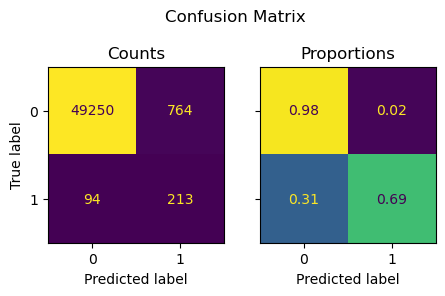

In [6]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=ax[0], colorbar=False)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_test,
    normalize="true",
    values_format=".2f",
    ax=ax[1],
    im_kw={"vmin": 0, "vmax": 1},
    colorbar=False,
)
fig.suptitle("Confusion Matrix")
ax[0].set_title("Counts")
ax[1].set_title("Proportions")
ax[1].set_ylabel(None)
fig.savefig(f"../figures/optimised.catBoost.cm.png")

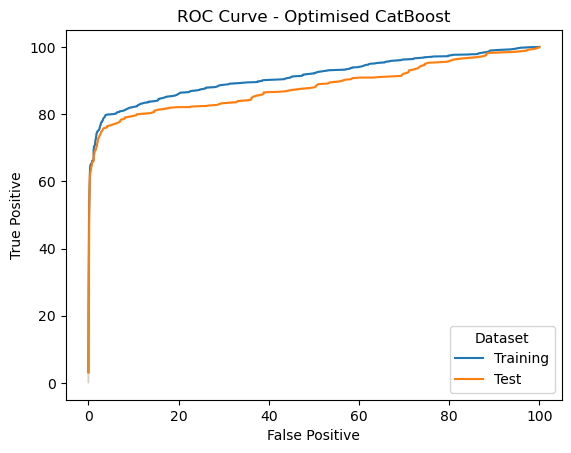

In [7]:
def make_roc_df(name, predictions, labels):
    fp, tp, _ = roc_curve(labels, predictions)
    return pd.DataFrame(
        {"False Positive": fp * 100, "True Positive": tp * 100, "Dataset": name}
    )


roc_df = pd.concat(
    [
        make_roc_df("Training", y_proba_train[:, -1], y_train),
        make_roc_df("Test", y_proba_test[:, -1], y_test),
    ]
)

sns.lineplot(roc_df, x="False Positive", y="True Positive", hue="Dataset")
plt.title("ROC Curve - Optimised CatBoost")
plt.show()